## Vehicle Detection Project
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

### Vehicles and Non-Vehicles Data Visualization

vehicle_images length: 8792
nonvehicle_images length: 8968
shape: (64, 64, 3)
shape: (64, 64, 3)


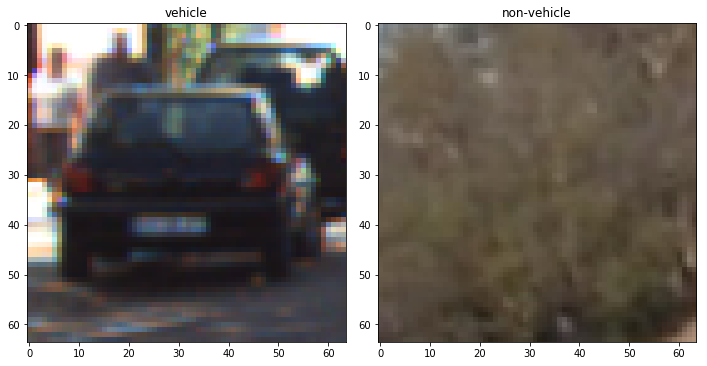

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

vehicle_images = glob.glob('vehicles/**/*.png')
nonvehicle_images = glob.glob('non-vehicles/**/*.png')
print("vehicle_images length:" , len(vehicle_images))
print("nonvehicle_images length:" , len(nonvehicle_images))


grid = gridspec.GridSpec(1, 2)
grid.update(wspace=0.1, hspace=0.02)
plt.figure(figsize=(12, 12))
for i in range(2):
    ax = plt.subplot(grid[i])
    ax.set_aspect('equal')
    if i < 1:
        ax.set_title("vehicle")
        img = cv2.imread(vehicle_images[np.random.randint(0,len(vehicle_images))])
    else:
        ax.set_title("non-vehicle")
        img = cv2.imread(nonvehicle_images[np.random.randint(0,len(nonvehicle_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    ax.imshow(img)
    print("shape:", img.shape)

plt.show()

### Histogram of Oriented Gradients (HOG) Function

In [2]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Text(0.5,1,'Non-Vehicle HOG')

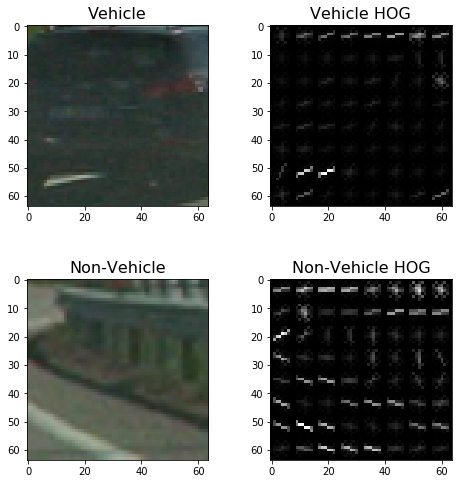

In [3]:
# Test Hog Function
orient = 9
pix_per_cell = 8
cell_per_block = 2

vehicle_img = mpimg.imread(vehicle_images[np.random.randint(0,len(vehicle_images))])
features, vehicle_hog_image = get_hog_features(vehicle_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

nonvehicle_img = mpimg.imread(nonvehicle_images[np.random.randint(0,len(vehicle_images))])
features, nonvehicle_hog_image = get_hog_features(nonvehicle_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(hspace = .4, wspace=.2)

ax1.imshow(vehicle_img)
ax1.set_title('Vehicle', fontsize=16)

ax2.imshow(vehicle_hog_image, cmap='gray')
ax2.set_title('Vehicle HOG', fontsize=16)

ax3.imshow(nonvehicle_img)
ax3.set_title('Non-Vehicle', fontsize=16)

ax4.imshow(nonvehicle_hog_image, cmap='gray')
ax4.set_title('Non-Vehicle HOG', fontsize=16)

### Extract HOG Features Function

In [4]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### HOG Classify

Test below variables to find better accuracy.

| Label | Colorspace | Orientations | Pixels Per Cell | Cells Per Block | HOG Channel | Accuracy | Extract Time | Train Time |
| :---: | :--------: | :----------: | :-------------: | :-------------: | :---------: | :------: | :----------: | :--------: |
| 1     | RGB        | 9            | 8               | 2               | 0           | 89.95    | 30.36        | 17.89      |
| 2     | RGB        | 9            | 8               | 2               | 1           | 90.74    | 28.12        | 14.63      |
| 3     | RGB        | 9            | 8               | 2               | 2           | 91.81    | 30.54        | 14.33      |
| 4     | RGB        | 9            | 8               | 2               | ALL         | 92.68    | 84.73        | 29.86      |
| 5     | HSV        | 9            | 8               | 2               | ALL         | 95.47    | 94.53        | 21.85      |
| 6     | LUV        | 9            | 8               | 2               | ALL         | 95.97    | 96.68        | 21.25      |
| 7     | HLS        | 9            | 8               | 2               | ALL         | 95.69    | 102.61       | 23.09      |
| 8     | YUV        | 9            | 8               | 2               | ALL         | 96.79    | 91.48        | 19.42      |
| 9     | YCrCb      | 9            | 8               | 2               | ALL         | 96.62    | 88.79        | 18.98      |
| 10    | YCrCb      | 12           | 10              | 2               | ALL         | 96.42    | 112.13       | 15.36      |
| 11    | YCrCb      | 11           | 12              | 2               | ALL         | 96.48    | 58.04        | 9.18       |
| 12    | YCrCb      | 8            | 6               | 2               | ALL         | 95.21    | 145.07       | 32.30      |
| 13    | YCrCb      | 9            | 14              | 2               | ALL         | 96.62    | 40.91        | 4.92       |
| 14    | YCrCb      | 10           | 14              | 2               | ALL         | 97.02    | 38.69        | 4.05       |
| 15    | YCrCb      | 12           | 16              | 2               | ALL         | 97.61    | 42.69        | 3.34       |
| 16    | YUV        | 10           | 8               | 2               | ALL         | 98.11    | 60.8         | 18.43      |
| 17    | YUV        | 10           | 15              | 2               | ALL         | 96.06    | 44.75        | 1.97       |
| 18    | YUV        | 11           | 16              | 2               | ALL         | 97.33    | 36.11        | 1.91       |
| 19    | YUV        | 9            | 16              | 2               | ALL         | 97.55    | 42.31        | 3.02       |
| 20    | YUV        | 9            | 12              | 2               | ALL         | 96.79    | 42.45        | 6.78       |

In [5]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

cars = vehicle_images
notcars = nonvehicle_images

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


158.44 Seconds to extract HOG features...
Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5880


### Train a Classifier

In [6]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9783
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
0.00201 Seconds to predict 10 labels with SVC


### Multi-scale Windows

In [7]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [8]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

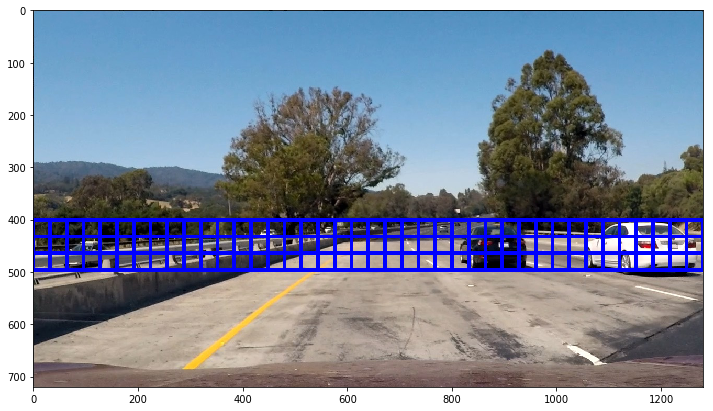

In [9]:
test_img = mpimg.imread('./test_images/test1.jpg')
x_start_stop = [None, None] # Min and max in x to search in slide_window()
y_start_stop = [400, 496] # Min and max in y to search in slide_window()
windows = slide_window(test_img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=6)
plt.figure(figsize=(12,12))
plt.imshow(window_img)
# mpimg.imsave("./examples/slide-windows1.png", window_img)

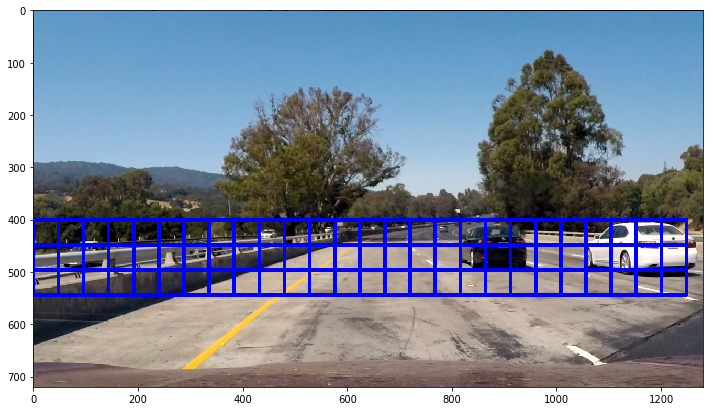

In [10]:
test_img = mpimg.imread('./test_images/test1.jpg')
x_start_stop = [None, None] # Min and max in x to search in slide_window()
y_start_stop = [400, 544] # Min and max in y to search in slide_window()
windows = slide_window(test_img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=6)
plt.figure(figsize=(12,12))
plt.imshow(window_img)
# mpimg.imsave("./examples/slide-windows2.png", window_img)

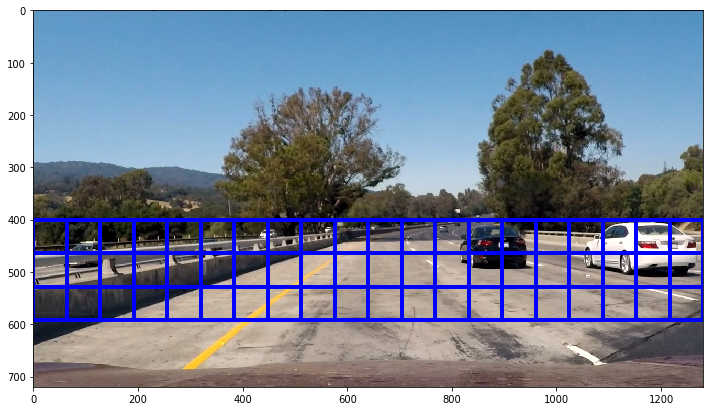

In [11]:
test_img = mpimg.imread('./test_images/test1.jpg')
x_start_stop = [None, None] # Min and max in x to search in slide_window()
y_start_stop = [400, 592] # Min and max in y to search in slide_window()
windows = slide_window(test_img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=6)
plt.figure(figsize=(12,12))
plt.imshow(window_img)
# mpimg.imsave("./examples/slide-windows3.png", window_img)

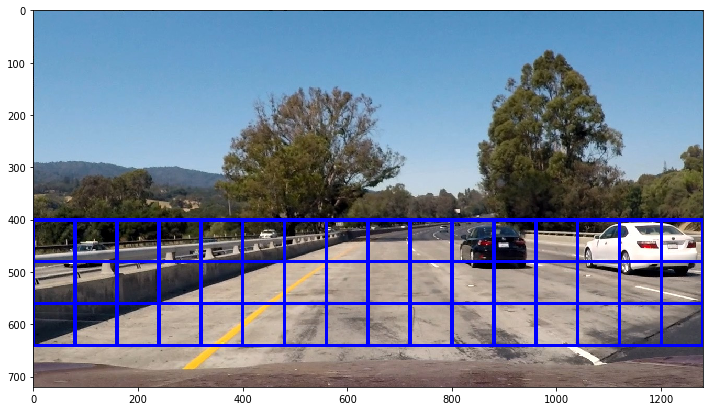

In [12]:
test_img = mpimg.imread('./test_images/test1.jpg')
x_start_stop = [None, None] # Min and max in x to search in slide_window()
y_start_stop = [400, 640] # Min and max in y to search in slide_window()
windows = slide_window(test_img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(160, 160), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=6)  
plt.figure(figsize=(12,12))
plt.imshow(window_img)
# mpimg.imsave("./examples/slide-windows4.png", window_img)

### Hog Sub-sampling Window Search

In [13]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# def bin_spatial(img, size=(32, 32)):
#     color1 = cv2.resize(img[:,:,0], size).ravel()
#     color2 = cv2.resize(img[:,:,1], size).ravel()
#     color3 = cv2.resize(img[:,:,2], size).ravel()
#     return np.hstack((color1, color2, color3))
                        
# def color_hist(img, nbins=32):    #bins_range=(0, 256)
#     # Compute the histogram of the color channels separately
#     channel1_hist = np.histogram(img[:,:,0], bins=nbins)
#     channel2_hist = np.histogram(img[:,:,1], bins=nbins)
#     channel3_hist = np.histogram(img[:,:,2], bins=nbins)
#     # Concatenate the histograms into a single feature vector
#     hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#     # Return the individual histograms, bin_centers and feature vector
#     return hist_features

In [14]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    rectangles = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))   
    
            test_features = X_scaler.transform(np.array(hog_features).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return rectangles

/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


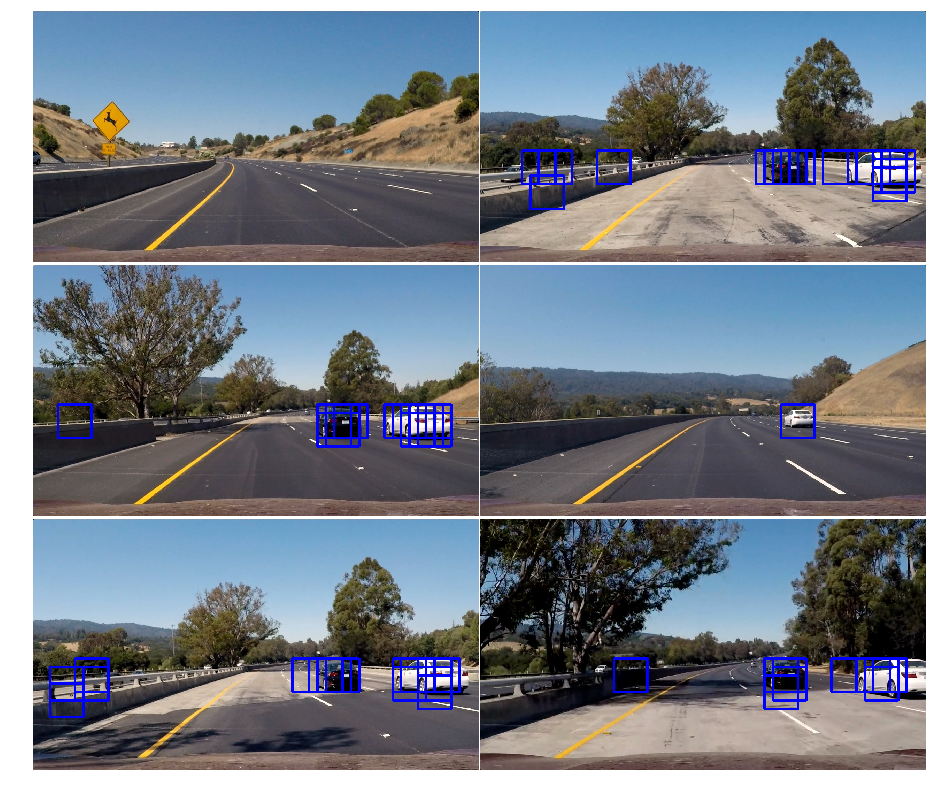

In [17]:
test_images = glob.glob('./test_images/test*.jpg')

ystart = 400
ystop = 592
scale = 1.5
spatial_size = (32, 32)
hist_bins = 32

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, img in enumerate(test_images):
    test_img = mpimg.imread(img)
    rectangles = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_img = draw_boxes(test_img, rectangles, color=(0, 0, 255), thick=6)   
    axs[i].imshow(out_img)
    axs[i].axis('off')

### Multiple Detection

/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


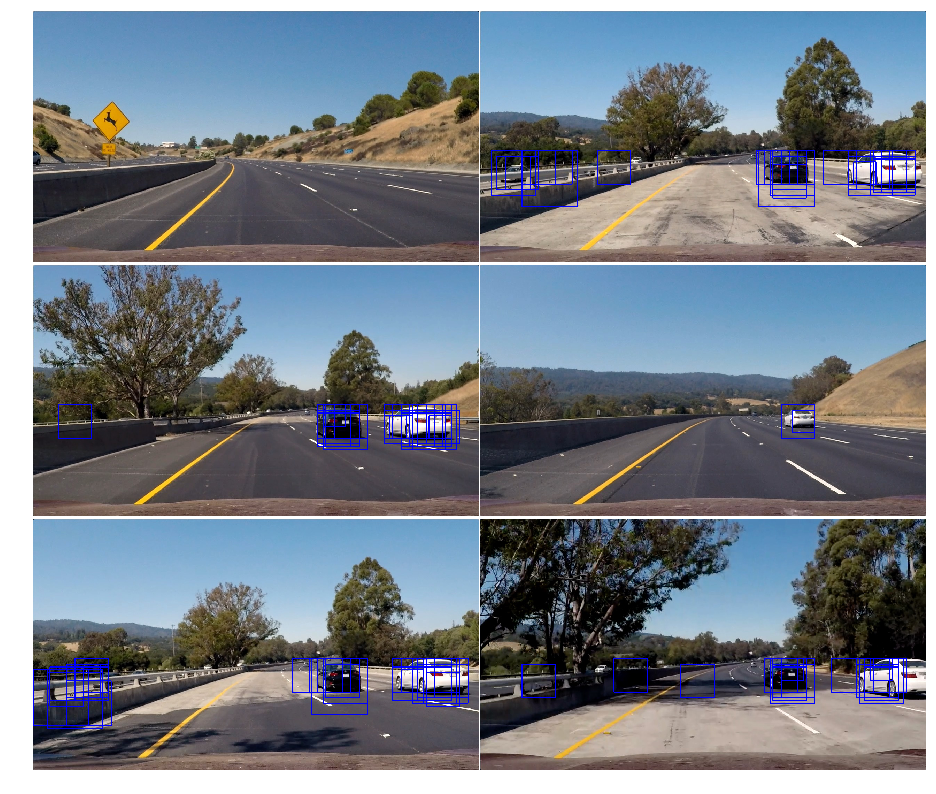

In [47]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

ori_images = []
result_images = []
result_rects = []

for i, img in enumerate(test_images):
    test_img = mpimg.imread(img)
    ori_images.append(test_img)
    
    rects = []

    ystart = 400
    ystop = 496
    scale = 1.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 416
    ystop = 512
    scale = 1.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    ystart = 400
    ystop = 544
    scale = 1.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 416
    ystop = 560
    scale = 1.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    ystart = 400
    ystop = 592
    scale = 2.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 432
    ystop = 624
    scale = 2.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    ystart = 400
    ystop = 640
    scale = 2.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 432
    ystop = 672
    scale = 2.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    rectangles = [item for sublist in rects for item in sublist] 
    test_img_rects = draw_boxes(test_img, rectangles, color=(0, 0, 255), thick=2)
    result_rects.append(rectangles)
    result_images.append(test_img_rects)
    axs[i].imshow(test_img_rects)
    axs[i].axis('off')

### False Positive

### Heatmap

In [23]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

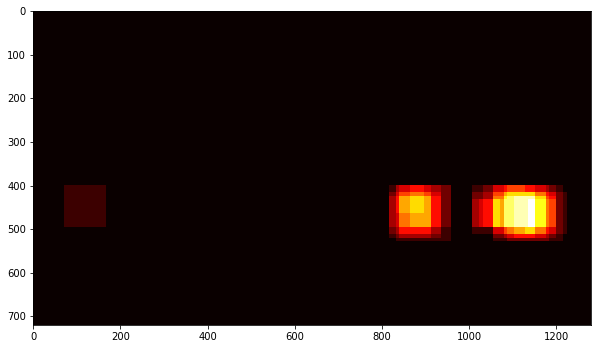

In [41]:
# Test out the heatmap
test_img = result_images[2]
rectangles = result_rects[2]

heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
heatmap_img = add_heat(heat, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
# plt.imsave("./examples/out_heatmap.png", heatmap_img, cmap='hot')

### Apply a Threshold to the Heatmap

In [42]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


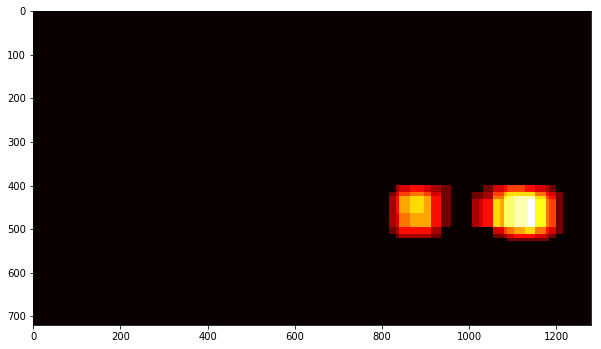

In [43]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
# plt.imsave("./examples/out_heatmap_threshold.png", heatmap_img, cmap='hot')

### Apply Labels to Heatmap

2 cars found


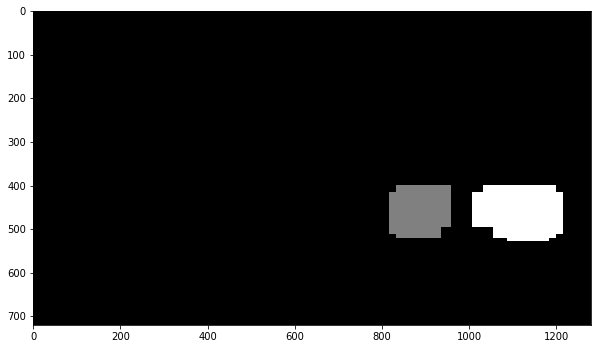

In [45]:
from scipy.ndimage.measurements import label

labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')
# plt.imsave("./examples/out_heatmap_threshold_label.png", labels[0], cmap='gray')

### Draw Bounding Boxes for Lables

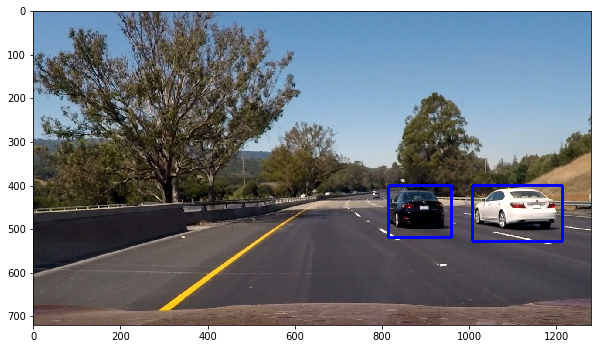

In [49]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

img = ori_images[2]
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
# mpimg.imsave("./examples/out_label_bbox.png", draw_img)

### Put it All Together

In [50]:
def process_frame(test_img):
    
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 10
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

    rects = []

    ystart = 400
    ystop = 496
    scale = 1.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 416
    ystop = 512
    scale = 1.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    ystart = 400
    ystop = 544
    scale = 1.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 416
    ystop = 560
    scale = 1.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    ystart = 400
    ystop = 592
    scale = 2.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 432
    ystop = 624
    scale = 2.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    ystart = 400
    ystop = 640
    scale = 2.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 432
    ystop = 672
    scale = 2.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    rectangles = [item for sublist in rects for item in sublist] 
    
    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 2)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    return draw_img

Run the pipeline on all the test images.

/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


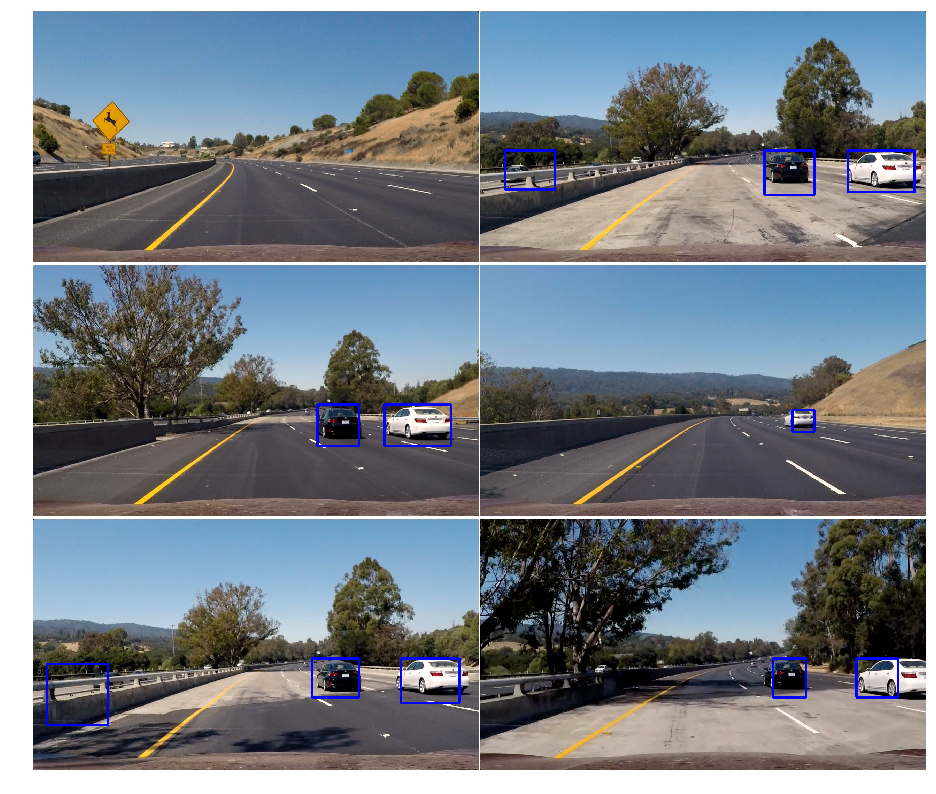

In [51]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, img in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(img)))
    axs[i].axis('off')


### Video Test

In [284]:
from moviepy.editor import VideoFileClip

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:23<00:00,  1.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 24.1 s, sys: 225 ms, total: 24.4 s
Wall time: 25 s


### Define a Class to Store Data from Vehicle Detections

In [293]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

### Pipeline for Processing Video Frames

In [304]:
def process_frame_for_video(test_img):

    rectangles = []
    
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 10
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

    rects = []

    ystart = 400
    ystop = 496
    scale = 1.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 416
    ystop = 512
    scale = 1.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    ystart = 400
    ystop = 544
    scale = 1.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 416
    ystop = 560
    scale = 1.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    ystart = 400
    ystop = 592
    scale = 2.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 432
    ystop = 624
    scale = 2.0
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    ystart = 400
    ystop = 640
    scale = 2.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 432
    ystop = 672
    scale = 2.5
    rects.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


 
    rectangles = [item for sublist in rects for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(test_img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 2 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    return draw_img

### Test Video with Pipiline

In [305]:
det = Vehicle_Detect()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:23<00:00,  1.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 23.9 s, sys: 255 ms, total: 24.2 s
Wall time: 24.7 s


### Run project video

In [306]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [13:22<00:00,  1.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 13min 29s, sys: 5.68 s, total: 13min 34s
Wall time: 13min 23s
